# TROPESS Demonstration of Ozone Data from CrIS and OMI Satellite Instruments

[![Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/NASA-TROPESS/binders/HEAD?labpath=https%3A%2F%2Fgithub.com%2FNASA-TROPESS%2Fbinders%2Fblob%2Fmain%2FIGAC2024_TROPESS_cris_omi_ozone_demo_integrated_download_4binder.ipynb)

This notebook demonstrates how to open TROPESS data, manipulate the data, and make figures including time series, maps, and atmospheric profiles. We analyze ozone data from the CrIS and OMI satellite instruments for 2 weeks in July 2022.

This tutorial requires the prior download of TROPESS data. The data can be found on [NASA Earthdata](https://disc.gsfc.nasa.gov/datasets?page=1&project=TROPESS). Tools to download data from the [command line](https://github.com/NASA-TROPESS/tutorials_notebooks/blob/main/data_subscriber_downloader.md) and within [Python](https://github.com/NASA-TROPESS/tutorials_notebooks/blob/main/earthaccess_https_download_megacities_los_angeles.ipynb) can be found at the [TROPESS Tutorials Page](https://github.com/NASA-TROPESS/tutorials_notebooks?tab=readme-ov-file).

### File options
There are 2 options when selecting time periods and data coverage:
1. Forward: Full dataset processed from ~2021 to the present.
2. Reanalysis: Long-term record processed from the beginning of satellite data collection up to the start of the Forward data. Contains ~10% of the data coverage as the Forward data, but this will be updated.

There are also 2 options when selecting variable availability:
1. Standard: Contains data that can be used for scientific and diagnostic analyses.
2. Summary: Contains a limited set of data for scientific analyses. Approximately ~10% the size of Standard files.

This notebook will download CrIS-SNPP and OMI data for July 10-23, 2022 using the links below.
* CrIS Forward Standard ([doi:10.5067/8LMUGJ8X1ZXB](https://disc.gsfc.nasa.gov/datasets/TRPSDL2O3CRSFS_1/summary))
* CrIS Forward Summary ([doi:10.5067/LT66296ATQD7](https://disc.gsfc.nasa.gov/datasets/TRPSYL2O3CRSFS_1/summary))
* OMI Forward Standard ([doi:10.5067/HL2UFH62ELJO](https://disc.gsfc.nasa.gov/datasets/TRPSDL2O3OMIFS_1/summary))
* OMI Forward Summary ([doi:10.5067/ZFQQYOR9H4OX](https://disc.gsfc.nasa.gov/datasets/TRPSYL2O3OMIFS_1/summary))

The files will be downloaded in a local folder named "data/".

### Other important notes:
1. This code was designed and tested **"as-is"** to run directly within a **local JupyterLab** environment.     

2. All dependencies within this notebook are also available in the latest **([environment.yml](https://github.com/NASA-TROPESS/IGAC-ShortCourse/blob/main/environment.yml))** file, which may be optionally used alongside this notebook to create, maintain and activate a dedicated conda environment (**tropess-igac-env**) and Python notebook kernel.

3. Please "trust" this notebook before executing; this will prevent errors when writing output to your local directory.


### Notebook Contacts
Kevin W. Bowman (kevin.w.bowman@jpl.nasa.gov) / Jet Propulsion Laboratory

Elyse A. Pennington (elyse.a.pennington@jpl.nasa.gov) / Jet Propulsion Laboratory

David F. Moroni (david.f.moroni@jpl.nasa.gov) / Jet Propulsion Laboratory

### Acknowledgements

This research was carried out at the Jet Propulsion Laboratory, California Institute of Technology, under a contract with the National Aeronautics and Space Administration (80NM0018D0004). Government sponsorship acknowledged.

## Getting started

### Python libraries
The following libraries are required to complete this demonstration:
* netCDF4.Dataset: to open the netCDF4 files
* numpy: to work with the data
* pandas: another method for working with the data
* datetime: to convert dates (stored as integers) to a more-usable datetime format
* matplotlib.pyplot: to create figures
* matplotlib.dates.mdates: to format how dates are labeled along a figure axis
* matplotlib.ticker: to assign tick locations on a figure
* mpl_toolkits.basemap.Basemap: one method to create maps
* cartopy and associated functions: another method to create maps

### User options
In this demonstration, the user can choose to look at data from CrIS or OMI and for any time period. For now, we'll use CrIS and the period from 2022-07-10 to 2022-07-23. The descriptions in the Markdown cells relate to CrIS.

Once you run through all of the code, come back and replace CrIS with OMI, and notice the differences between the CrIS and OMI datasets.


In [1]:
# import libraries
import requests
import earthaccess
from earthaccess import Auth, Store, DataCollections, DataGranules
auth = Auth()
import os
import contextlib
import numpy as np
from netCDF4 import Dataset
import pandas as pd
import datetime
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as mticker
from mpl_toolkits.basemap import Basemap
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeat
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER


# select dates
start_date = '2022-07-10'
end_date = '2022-07-23'

# Verify Successful Authentication to NASA Earthdata¶
Prompt for NASA Earthdata Login Credentials (if .netrc file doesn't already exist)
A .netrc file will be created if it doesn't already exist.

In [2]:
%%time

# Using earthacces library to provide interactie authentication.
auth = earthaccess.login(strategy="interactive", persist=True)

auth.login(strategy="netrc")
authvalid = auth.authenticated
print('Authenication Valid =',authvalid)

# The Store() class enables download or access to data and is instantiated with the user's auth instance.
store = Store(auth)

Authenication Valid = True
CPU times: user 37.7 ms, sys: 10 ms, total: 47.7 ms
Wall time: 6.78 s


# Now we will create the local output directory paths if they do not already exist.

In [3]:
%%time

data_dir_check = os.path.isdir('data')
print("Data directory exists: ",data_dir_check)

images_dir_check = os.path.isdir('images')
print("Images directory exists: ",images_dir_check)

if data_dir_check != True: os.makedirs('data')
if images_dir_check != True: os.makedirs('images')

Data directory exists:  True
Images directory exists:  True
CPU times: user 439 μs, sys: 549 μs, total: 988 μs
Wall time: 543 μs


# Create a Function for CMR Catalog Requests

In [4]:
%%time

def cmr_request(params):
    response = requests.get(url,
                        params=params,
                        headers={
                            'Accept': 'application/json',
                        }
                       )
    return response

CPU times: user 2 μs, sys: 1 μs, total: 3 μs
Wall time: 5.72 μs


# Search CMR Catalogs and Obtain HTTPS URLs
## Check that the CMR catalog can be accessed

If "200, CMR is accessible" is returned, the catalog can be accessed!

In [5]:
%%time

url = 'https://cmr.earthdata.nasa.gov/search/collections'

# Create our request for finding cloud-hosted granules, and check that we can access CMR
response = cmr_request({
                        'cloud_hosted': 'True',
                        'has_granules': 'True'
                        })

if response.status_code == 200:
    print(str(response.status_code) + ", CMR is accessible")
else:
    print(str(response.status_code) + ", CMR is not accessible, check for outages")

200, CMR is accessible
CPU times: user 4.52 ms, sys: 2.56 ms, total: 7.08 ms
Wall time: 1.16 s


# Use EarthAccess to Search CMR with your desired data collection's shortname, bounding box and desired date range

Using the collection's DOI, we can obtain individual granules by directly querying the CMR API.

From the CMR query, we will dynamically, through user-interactive prompts, parse out an HTTPS URL for the following datasets wihthin each satellite grouping:
1. CrIS-SNPP  
    a. CrIS Forward Standard (doi:10.5067/8LMUGJ8X1ZXB)  
    b. CrIS Forward Summary (doi:10.5067/LT66296ATQD7)
2. OMI-Aura:  
    a. OMI Forward Standard (doi:10.5067/HL2UFH62ELJO)  
    b. OMI Forward Summary (doi:10.5067/ZFQQYOR9H4OX)
    
    
The desired date range is defined in the first cell of the notebook.

In [6]:
%%time

# Define satellite data sources
sources = ['CRIS','OMI']

# Define Dictionaries for satellite data sources
cris_std =	{
  "fam": "CRIS",
  "doi": "10.5067/8LMUGJ8X1ZXB",
  "type1": "standard",
  "type2": "forward"
} 

cris_sum =	{
  "fam": "CRIS",
  "doi": "10.5067/LT66296ATQD7",
  "type1": "summary",
  "type2": "forward"
} 

omi_std =	{
  "fam": "OMI",
  "doi": "10.5067/HL2UFH62ELJO",
  "type1": "standard",
  "type2": "forward"
} 

omi_sum =	{
  "fam": "OMI",
  "doi": "10.5067/ZFQQYOR9H4OX",
  "type1": "summary",
  "type2": "forward"
} 

# Create a combined dictionary of previously defined dictionaries
combined_dict = []
combined_dict.append(cris_std)
combined_dict.append(cris_sum)
combined_dict.append(omi_std)
combined_dict.append(omi_sum)

# Print the contents of the combined dictionary
combined_dict

print('Available Satellite Sources: ',sources)
target_fam = input("Enter Target Satellite Source (case sensitive): ")
print('You selected: ',target_fam)

# Verify correct source matchup; if correct, then execute For loop to search for granules
target_dict = next((item for item in combined_dict if item['fam'] == target_fam), None)
print('Target Dictionary = ',target_dict)
if target_dict == None: 
    print('Your selection did not match the available options.')
    print('Please re-run this cell to get a correct source match.')    
else:
# For loop to search for granules within the target_source
        for item in combined_dict:
            if target_fam == item['fam']:
                print('Dataset matchup = ', item)
                doi=item['doi']
                print('Dataset DOI: ', doi)
                query = DataGranules().doi(doi).temporal(start_date, end_date)
                
                # How many granules are located in the query?
                print(f"Granule hits: {query.hits()}")

                # Extract all available granule metadata from the query; invoking "-1" for all avaialble granules.
                granules = query.get()

                # Print granule metadata
                print(granules)
                
                #Now download the data files from the granule metadata
                files = store.get(granules[:], local_path="./data")
                
# Remove .netrc file
!rm .netrc

Available Satellite Sources:  ['CRIS', 'OMI']
Enter Target Satellite Source (case sensitive): CRIS
You selected:  CRIS
Target Dictionary =  {'fam': 'CRIS', 'doi': '10.5067/8LMUGJ8X1ZXB', 'type1': 'standard', 'type2': 'forward'}
Dataset matchup =  {'fam': 'CRIS', 'doi': '10.5067/8LMUGJ8X1ZXB', 'type1': 'standard', 'type2': 'forward'}
Dataset DOI:  10.5067/8LMUGJ8X1ZXB
Granule hits: 14
[Collection: {'ShortName': 'TRPSDL2O3CRSFS', 'Version': '1'}
Spatial coverage: {'HorizontalSpatialDomain': {'Geometry': {'BoundingRectangles': [{'WestBoundingCoordinate': -180.0, 'EastBoundingCoordinate': 180.0, 'NorthBoundingCoordinate': 85.0, 'SouthBoundingCoordinate': -67.0}]}}}
Temporal coverage: {'RangeDateTime': {'BeginningDateTime': '2022-07-10T00:00:00.000Z', 'EndingDateTime': '2022-07-10T23:59:59.000Z'}}
Size(MB): 164.09299278259277
Data: ['https://data.gesdisc.earthdata.nasa.gov/data/TROPESS_Standard/TRPSDL2O3CRSFS.1/2022/TROPESS_CrIS-SNPP_L2_Standard_O3_20220710_MUSES_R1p17_FS_F0p4.nc'], Collect

QUEUEING TASKS | :   0%|          | 0/14 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/14 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/14 [00:00<?, ?it/s]

Dataset matchup =  {'fam': 'CRIS', 'doi': '10.5067/LT66296ATQD7', 'type1': 'summary', 'type2': 'forward'}
Dataset DOI:  10.5067/LT66296ATQD7
Granule hits: 14
[Collection: {'ShortName': 'TRPSYL2O3CRSFS', 'Version': '1'}
Spatial coverage: {'HorizontalSpatialDomain': {'Geometry': {'BoundingRectangles': [{'WestBoundingCoordinate': -180.0, 'EastBoundingCoordinate': 180.0, 'NorthBoundingCoordinate': 85.0, 'SouthBoundingCoordinate': -67.0}]}}}
Temporal coverage: {'RangeDateTime': {'BeginningDateTime': '2022-07-10T00:00:00.000Z', 'EndingDateTime': '2022-07-10T23:59:59.000Z'}}
Size(MB): 8.782835006713867
Data: ['https://data.gesdisc.earthdata.nasa.gov/data/TROPESS_Summary/TRPSYL2O3CRSFS.1/2022/TROPESS_CrIS-SNPP_L2_Summary_O3_20220710_MUSES_R1p17_FS_F0p6.nc'], Collection: {'ShortName': 'TRPSYL2O3CRSFS', 'Version': '1'}
Spatial coverage: {'HorizontalSpatialDomain': {'Geometry': {'BoundingRectangles': [{'WestBoundingCoordinate': -180.0, 'EastBoundingCoordinate': 180.0, 'NorthBoundingCoordinate': 8

QUEUEING TASKS | :   0%|          | 0/14 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/14 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/14 [00:00<?, ?it/s]

CPU times: user 119 ms, sys: 51.4 ms, total: 170 ms
Wall time: 6.1 s


### Data Processing Steps

We begin by opening the data and performing the following steps on each day:
1. Open data from both the Standard and Summary products. The Standard product provides most of the information we need (lat/lon, time stamp, ozone profiles, pressure levels, AK, DOFS, cloud EOD), while the Summary product provides column quantities (col and col_t).
2. Convert time stamps to a more usable format.
3. Select geographic domains of interest. In this example, we'll look at:
* global maps
* regional average over the US
* a single clear-sky sounding over SE Asia
* a single cloudy sounding over SE Asia
4. Add the daily data to a weekly record.

In this example, we focus on the Forward Products, but this code can be used to analyze Reanalysis datasets as well.

First, define geographic regimes and variables of interest. Convert the user-requested start and end dates from above into Python's datetime.atetime format. Also define some variables/structures to hold the data once it's been opened.

In [7]:
%%time

# define the lat/lon limits for a specified region
location = 'SE Asia'
lat_min_loc = -11.0
lat_max_loc = 22.0
lon_min_loc = 90.0
lon_max_loc = 155.0

# define the lat/lon limits for the US
lat_min_US = 28.0
lat_max_US = 50.0
lon_min_US = -125.0
lon_max_US = -70.0

# define the variables we want to extract
var_list_standard = [ 'longitude', 'latitude', 'time', 'pressure', 'x', 'average_cloud_eod', 'land_flag', 'averaging_kernel', 'signal_dof' ]
var_list_summary = [ 'col', 'col_t' ]

# define unreasonable placeholder values for cloud EOD
ceod_min = 1e20
ceod_max = -1*1e20

# reformat the requested dates and find the total number of days requested
sdate = datetime.datetime.strptime( start_date, '%Y-%m-%d' )
edate = datetime.datetime.strptime( end_date, '%Y-%m-%d' )
total_numdays = edate - sdate
total_numdays = total_numdays.days + 1

# create dictionaries to put daily-averaged data in
d_all = {}
d_US = {}
d_loc_clear = {}
d_loc_cloud = {}
for var in var_list_standard+var_list_summary:
    d_all[var] = []
    d_US[var] = []
    d_loc_clear[var] = []
    d_loc_cloud[var] = []

CPU times: user 415 μs, sys: 32 μs, total: 447 μs
Wall time: 452 μs


### Next, we define functions to open the data files.
* open_standard is used to extract a set of variables from the standard files
* open_summary is used to extract a different set of variables from the standard files

### Function to extract standard files

In [8]:
%%time

def open_standard( satellite, date_string ):
    
    # create dictionaries to hold data for this one day
    d_day = {}
    
    # open Standard file according to requested satellite and date
    if satellite == 'CRIS':
        # open the file and log the date if this day's data exists
        try:
            infile = Dataset( f'data/TROPESS_CrIS-SNPP_L2_Standard_O3_{date_string}_MUSES_R1p17_FS_F0p4.nc', 'r' )
        # if the file doesn't exist, skip this date
        except:
            print( f'\tno {satellite} data on {date_string}' )
    elif satellite == 'OMI':
        # open the file and log the date if this day's data exists
        try:
            infile = Dataset( f'data/TROPESS_OMI-Aura_L2_Standard_O3_{date_string}_MUSES_R1p17_FS_F0p4.nc', 'r' )
        # if the file doesn'r exist, skip this date
        except:
            print( f'\tno {satellite} data on {date_string}' )
    else:
        raise Exception( 'This demo only works with CRIS or OMI!' )
    
    # extract requested variables and assign them to the dictionary's lists
    for var in var_list_standard:
        # some variables need to be extracted from groups in the file
        if var in ['average_cloud_eod','land_flag']:
            d_day[var] = np.array( infile.groups['geophysical'].variables[var] )
        elif var in ['averaging_kernel','signal_dof']:
            d_day[var] = np.array( infile.groups['observation_ops'].variables[var] )
        # all other variables are in the "main" group
        else:
            d_day[var] = np.array( infile.variables[var] )
    
    # close file
    infile.close()
    
    # return the dictionary for this day
    return d_day

CPU times: user 4 μs, sys: 1e+03 ns, total: 5 μs
Wall time: 7.15 μs


### Function to extract summary files

In [9]:
%%time

def open_summary( satellite, date_string, d_day ):

    # open Summary file according to requested satellite and date
    if satellite == 'CRIS':
        infile = Dataset( f'data/TROPESS_CrIS-SNPP_L2_Summary_O3_{date_string}_MUSES_R1p17_FS_F0p6.nc', 'r' )
    elif satellite == 'OMI':
        infile = Dataset( f'data/TROPESS_OMI-Aura_L2_Summary_O3_{date_string}_MUSES_R1p17_FS_F0p6.nc', 'r' )
    else:
        raise Exception( 'This demo only works with CRIS or OMI!' )
            
    # extract requested variables and add them to the dictionary that was created previously when openeing the standard product
    for var in var_list_summary:
        d_day[var] = np.array( infile.variables[var] )
    
    # close file
    infile.close()
    
    # -999 is the fill value for nonexistent or bad data - replace it with nans
    for var in d_day.keys():
        if var in ['time','land_flag']:
            continue
        d_day[var][ np.where( d_day[var] == -999 ) ] = np.nan
    
    # return dictionary
    return d_day

CPU times: user 4 μs, sys: 1 μs, total: 5 μs
Wall time: 7.87 μs


### Read in the data from the data files

In [10]:
%%time

# Define satellite identifer
satellite = target_fam

# loop through each day
for numday in range(total_numdays):
    
    # get the date for this loop
    date = sdate + datetime.timedelta( days=numday )
    print( f'Getting data on {date.strftime( "%Y-%m-%d" )}' ) 
    date_string = date.strftime( '%Y%m%d' )
    
    # create dictionaries to hold data for this day at the 2 regions we defined above
    d_day_US = {}
    d_day_loc = {}
    
    # get data from the Standard file on this day
    d_day = open_standard( satellite, date_string )
    
    # get data from the Summary file and update the dictionary
    d_day = open_summary( satellite, date_string, d_day )
    
    # append all data to a list to make daily global maps
    for var in d_day.keys():
        d_all[var].append( d_day[var] )
    
    # select only the data inside the United States limits, average it to get a daily mean, and append it to the weekly record
    US_selection = np.where( (d_day['latitude'] >= lat_min_US) & (d_day['latitude'] <= lat_max_US) & (d_day['longitude'] >= lon_min_US) & (d_day['longitude'] <= lon_max_US) )[0]
    for var in d_day.keys():
         d_US[var].append( np.nanmean( np.squeeze( d_day[var][US_selection] ), axis=0 ) )
    
    # select only the data inside the limits of SE Asia
    loc_selection = np.where( (d_day['latitude'] >= lat_min_loc) & (d_day['latitude'] <= lat_max_loc) & (d_day['longitude'] >= lon_min_loc) & (d_day['longitude'] <= lon_max_loc) )[0]
    for var in d_day.keys():
        d_day_loc[var] = np.squeeze( d_day[var][loc_selection] )
        
    # find the min and max cloud EOD on this day (only over land) and check whether it's less/greater than the weekly min/max cloud EODs
    ind = np.where( (d_day_loc['average_cloud_eod'] == np.nanmin(d_day_loc['average_cloud_eod'])) & (d_day_loc['land_flag'] == 1) )[0]
    if ind.size > 0:
        if d_day_loc['average_cloud_eod'][ind] < ceod_min:
            ceod_min = d_day_loc['average_cloud_eod'][ind][0]
            for var in d_day_loc.keys():
                d_loc_clear[var] = d_day_loc[var][ind]
    ind = np.where( (d_day_loc['average_cloud_eod'] == np.nanmax(d_day_loc['average_cloud_eod'])) & (d_day_loc['land_flag'] == 1) )[0]
    if ind.size > 0:
        if d_day_loc['average_cloud_eod'][ind] > ceod_max:
            ceod_max = d_day_loc['average_cloud_eod'][ind][0]
            for var in d_day_loc.keys():
                d_loc_cloud[var] = d_day_loc[var][ind]

Getting data on 2022-07-10
Getting data on 2022-07-11
Getting data on 2022-07-12
Getting data on 2022-07-13
Getting data on 2022-07-14
Getting data on 2022-07-15
Getting data on 2022-07-16
Getting data on 2022-07-17
Getting data on 2022-07-18
Getting data on 2022-07-19
Getting data on 2022-07-20
Getting data on 2022-07-21
Getting data on 2022-07-22
Getting data on 2022-07-23
CPU times: user 8.97 s, sys: 2.19 s, total: 11.2 s
Wall time: 11.6 s


### Data conversion step

After calculating daily means and adding them to weekly records, we convert the data to arrays and/or floats to make them more usable in future functions.

In the original files, the date is described as the number of seconds elapsed since Jan. 1, 1993 using the 'time' variable. We'll convert this to Python's datetime.datetime format which can be used to easily perform date manipulations and create timeseries.

In [11]:
%%time

# convert lists to numpy arrays or floats, depending on the shape of the variable
for var in d_US.keys():
    d_US[var] = np.array( d_US[var] )
    if var in ['pressure','x','averaging_kernel']:
        d_loc_clear[var] = np.squeeze( np.array( d_loc_clear[var] ) )
        d_loc_cloud[var] = np.squeeze( np.array( d_loc_cloud[var] ) )
    else:
        d_loc_clear[var] = float( d_loc_clear[var][0] )
        d_loc_cloud[var] = float( d_loc_cloud[var][0] )
    
# convert the times to a more-usable datetime format
st = datetime.datetime( 1993, 1, 1, 0 )
dt_clear = st + datetime.timedelta( seconds=int( d_loc_clear['time'] ) )
dt_cloud = st + datetime.timedelta( seconds=int( d_loc_cloud['time'] ) )
dt = [ st + datetime.timedelta( seconds=int(s) ) for s in d_US['time'] ]

CPU times: user 677 μs, sys: 743 μs, total: 1.42 ms
Wall time: 825 μs


### Print shapes and values for relevant data fields 

In [12]:
%%time

print( '\nUS-average variable shapes' )
for var in d_US.keys():
    print( f'\t{var} shape = {d_US[var].shape}' )
    
print( '\nGlobal map:' )
for i in range(len(d_all['latitude'])):
    print( f'\t# data points per day = {int(d_all["latitude"][i].shape[0])}' )

print( f'\nClear {location}' )
print( f'\tdt_clear = {dt_clear.strftime("%Y/%m/%d %H:%M:%S")}' )
print( f'\tx shape = {d_loc_clear["x"].shape}' )
print( f'\taverage_cloud_eod = {ceod_min}' )
print( f'\tlat, lon = {round(d_loc_clear["latitude"],2)}, {round(d_loc_clear["longitude"],2)}' )

print( f'\nCloudy {location}' )
print( f'\tdt_clear = {dt_cloud.strftime("%Y/%m/%d %H:%M:%S")}' )
print( f'\tx shape = {d_loc_cloud["x"].shape}' )
print( f'\taverage_cloud_eod = {ceod_max}' )
print( f'\tlat, lon = {round(d_loc_cloud["latitude"],2)}, {round(d_loc_cloud["longitude"],2)}' )


US-average variable shapes
	longitude shape = (14,)
	latitude shape = (14,)
	time shape = (14,)
	pressure shape = (14, 26)
	x shape = (14, 26)
	average_cloud_eod shape = (14,)
	land_flag shape = (14,)
	averaging_kernel shape = (14, 26, 26)
	signal_dof shape = (14,)
	col shape = (14,)
	col_t shape = (14,)

Global map:
	# data points per day = 36000
	# data points per day = 35765
	# data points per day = 35672
	# data points per day = 35751
	# data points per day = 35827
	# data points per day = 35489
	# data points per day = 35306
	# data points per day = 35379
	# data points per day = 36414
	# data points per day = 36703
	# data points per day = 35940
	# data points per day = 35754
	# data points per day = 35676
	# data points per day = 36075

Clear SE Asia
	dt_clear = 2022/07/16 07:09:31
	x shape = (26,)
	average_cloud_eod = 0.0013288325862959027
	lat, lon = 0.67, 101.24

Cloudy SE Asia
	dt_clear = 2022/07/11 18:02:39
	x shape = (26,)
	average_cloud_eod = 9.977280616760254
	lat, lon 

## Making maps

First we will look at a map of global tropospheric ozone. This code demonstrates one method for making maps: Basemap. We'll make a scatter plot of the data collected on start_date, colored by tropospheric column ozone.

### First map (below): Tropospheric Column Ozone for Single Day

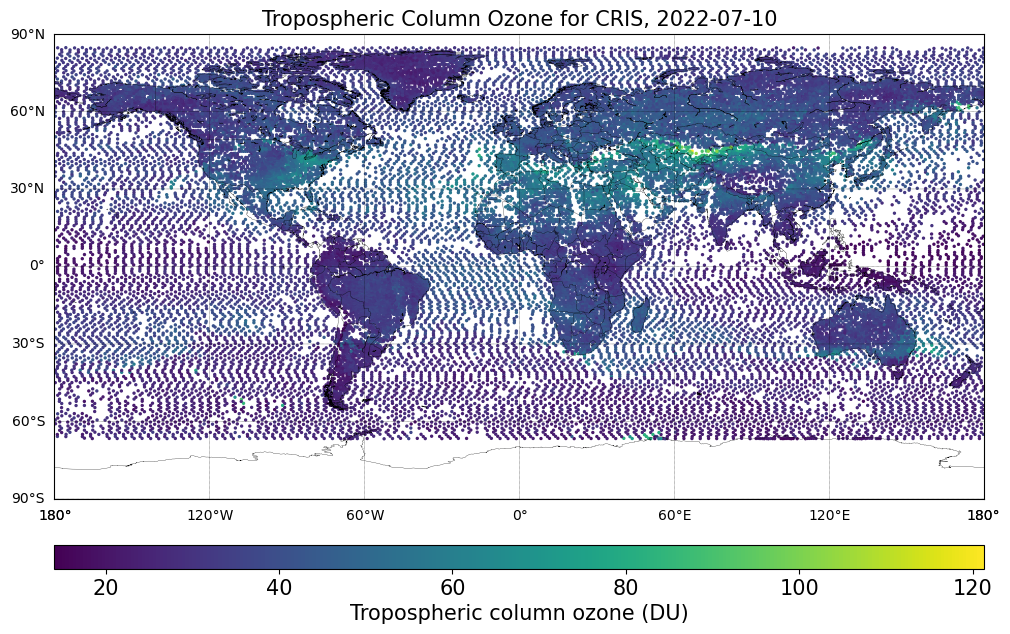

CPU times: user 2.52 s, sys: 69.1 ms, total: 2.59 s
Wall time: 2.61 s


In [13]:
%%time

# specify figure size (in inches)
plt.figure( figsize=(12, 8) )  

# create a basemap instance
m = Basemap( projection='cyl', resolution='l' )

# draw geographic features, including parallels (latitude lines) and meridians (longitude lines)
m.drawcoastlines(linewidth=0.2)
m.drawcountries(linewidth=0.2)
parallels = np.arange(-90., 91., 30.)
m.drawparallels(parallels, labels=[True,False,False,False], linewidth=0.3)
meridians = np.arange(-180., 181., 60.)
m.drawmeridians(meridians, labels=[False,False,False,True], linewidth=0.3)    

# plot a single day of data as a scatter plot (multiply col by 2241.147 to convert to Dobson Units)
sc = m.scatter( d_all['longitude'][0], d_all['latitude'][0], c=d_all['col_t'][0]*2241.147, cmap='viridis', s=2 )

# add a colorbar
cbar = m.colorbar( sc, location='bottom', pad='10%' )
cbar.ax.tick_params( labelsize=15 ) 
cbar.set_label( 'Tropospheric column ozone (DU)', fontsize=15 )

# add a title
plt.title( f'Tropospheric Column Ozone for {satellite}, {start_date}', fontsize=15 )

# Save figure to PNG file
plt.savefig(f'./images/tropess_{satellite}_tropospheric_column_ozone_{start_date}.png', dpi=300, bbox_inches='tight')

plt.show()
plt.close()

In the above figure, we see that the data distribution is nearly global after one day of data collection. Next, we will create the same map, but with data from the entire period of data that we opened (2 weeks). The globe has even greater coverage after extending the data collection period. This cell takes a few seconds to run as it loops through each day.

### 2nd Map (below): Tropospheric Column Ozone for 2 Weeks

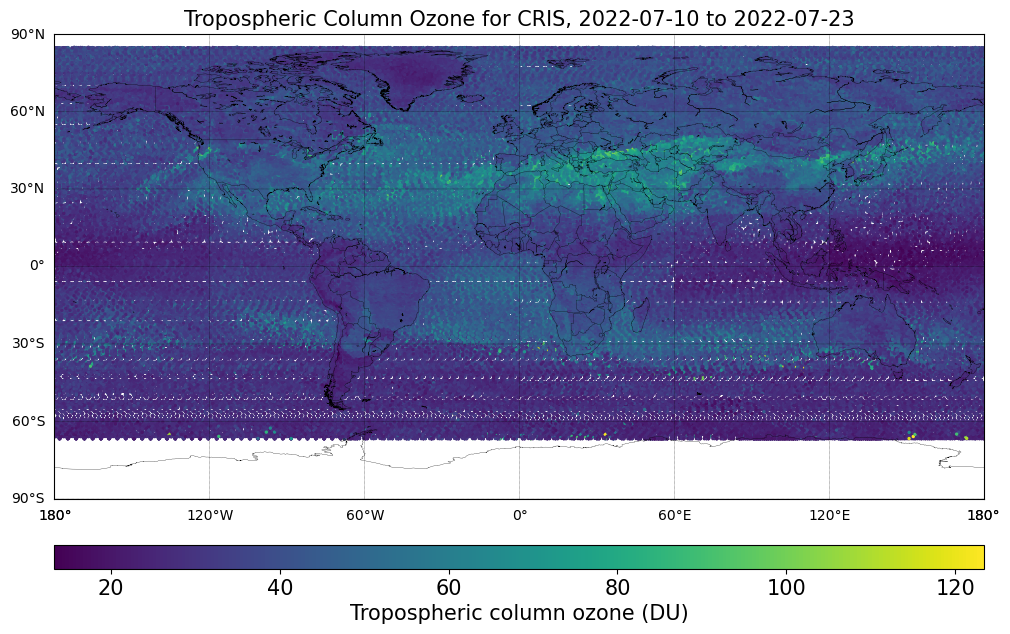

CPU times: user 17.1 s, sys: 347 ms, total: 17.5 s
Wall time: 17.3 s


In [14]:
%%time

# specify figure size (in inches)
plt.figure( figsize=(12, 8) )  

# create a basemap instance
m = Basemap( projection='cyl', resolution='l' )

# draw geographic features, including parallels (latitude lines) and meridians (longitude lines)
m.drawcoastlines(linewidth=0.2)
m.drawcountries(linewidth=0.2)
parallels = np.arange(-90., 91., 30.)
m.drawparallels(parallels, labels=[True,False,False,False], linewidth=0.3)
meridians = np.arange(-180., 181., 60.)
m.drawmeridians(meridians, labels=[False,False,False,True], linewidth=0.3)    

# plot every day of data as a scatter plot (multiply col by 2241.147 to convert to Dobson Units)
for i in range(len(d_all['latitude'])):
    sc = m.scatter( d_all['longitude'][i], d_all['latitude'][i], c=d_all['col_t'][i]*2241.147, cmap='viridis', s=2 )

# add a colorbar
cbar = m.colorbar( sc, location='bottom', pad='10%' )
cbar.ax.tick_params( labelsize=15 ) 
cbar.set_label( 'Tropospheric column ozone (DU)', fontsize=15 )

# add a title
plt.title( f'Tropospheric Column Ozone for {satellite}, {start_date} to {end_date}', fontsize=15 )

# Save figure to PNG file
plt.savefig(f'./images/tropess_{satellite}_tropospheric_column_ozone_{start_date}_to_{end_date}.png', dpi=300, bbox_inches='tight')

plt.show()
plt.close()

### 3rd Map (below): Cropping Previous Map over SE Asia

We can also use Basemap to crop the image to a specific region. Here we plot the map over the region we chose above, SE Asia, using the full 2 weeks of data.

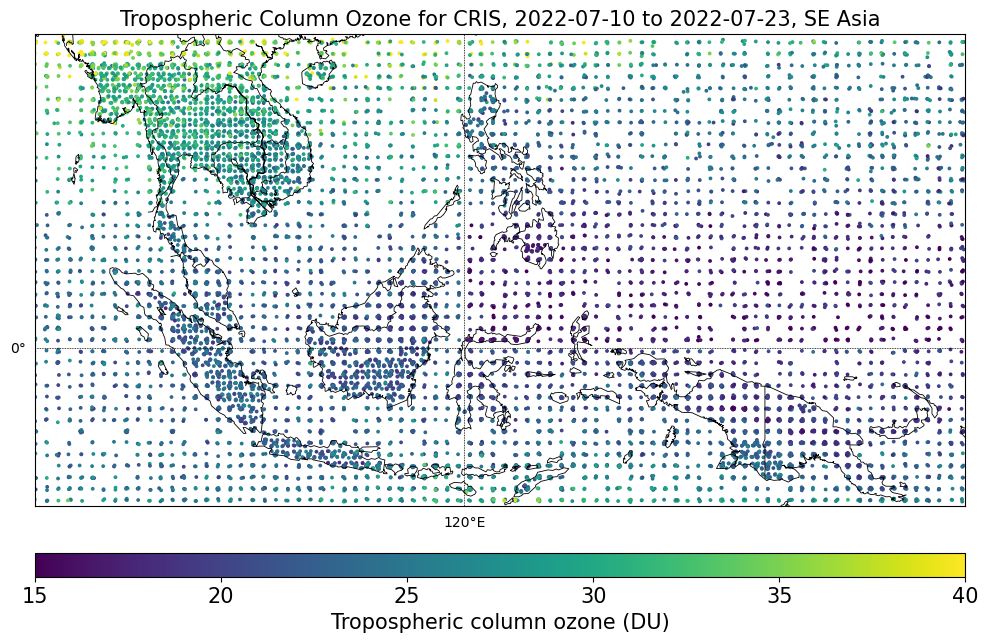

CPU times: user 10.9 s, sys: 148 ms, total: 11 s
Wall time: 11 s


In [15]:
%%time

# specify figure size (in inches)
plt.figure( figsize=(12, 8) )  

# create a basemap instance
m = Basemap( projection='cyl', resolution='l', llcrnrlat=lat_min_loc, urcrnrlat=lat_max_loc, llcrnrlon=lon_min_loc, urcrnrlon=lon_max_loc )

# draw geographic features, including parallels (latitude lines) and meridians (longitude lines)
m.drawcoastlines(linewidth=0.6, color='k')
m.drawcountries(linewidth=0.6, color='k')
parallels = np.arange(-90., 91., 30.)
m.drawparallels(parallels, labels=[True,False,False,False], linewidth=0.6, color='k')
meridians = np.arange(-180., 181., 60.)
m.drawmeridians(meridians, labels=[False,False,False,True], linewidth=0.6, color='k')    

# plot every day of data as a scatter plot (multiply col by 2241.147 to convert to Dobson Units)
for i in range(len(d_all['latitude'])):
    sc = m.scatter( d_all['longitude'][i], d_all['latitude'][i], c=d_all['col_t'][i]*2241.147, cmap='viridis', s=3, vmin=15, vmax=40 )

# add a colorbar
cbar = m.colorbar( sc, location='bottom', pad='10%' )
cbar.ax.tick_params( labelsize=15 ) 
cbar.set_label( 'Tropospheric column ozone (DU)', fontsize=15 )

# add a title
plt.title( f'Tropospheric Column Ozone for {satellite}, {start_date} to {end_date}, {location}', fontsize=15 )

# Save figure to PNG file
plt.savefig(f'./images/tropess_{satellite}_tropospheric_column_ozone_{start_date}_to_{end_date}_{location}.png', dpi=300, bbox_inches='tight')

plt.show()
plt.close()

### 4th Map (below): Global map of the DOFS for the 2-week period


Another variable that we extracted from the Standard file was signal_dof: Degrees of Freedom for Signal (DOFS). This quantity describes the sensitivity of the instrument to distinguish features throughout the atmosphere. A large DOFS corresponds to a high ability of the instrument to resolve features of the total atmospheric profile. It is calculated as the trace of the averaging kernel.

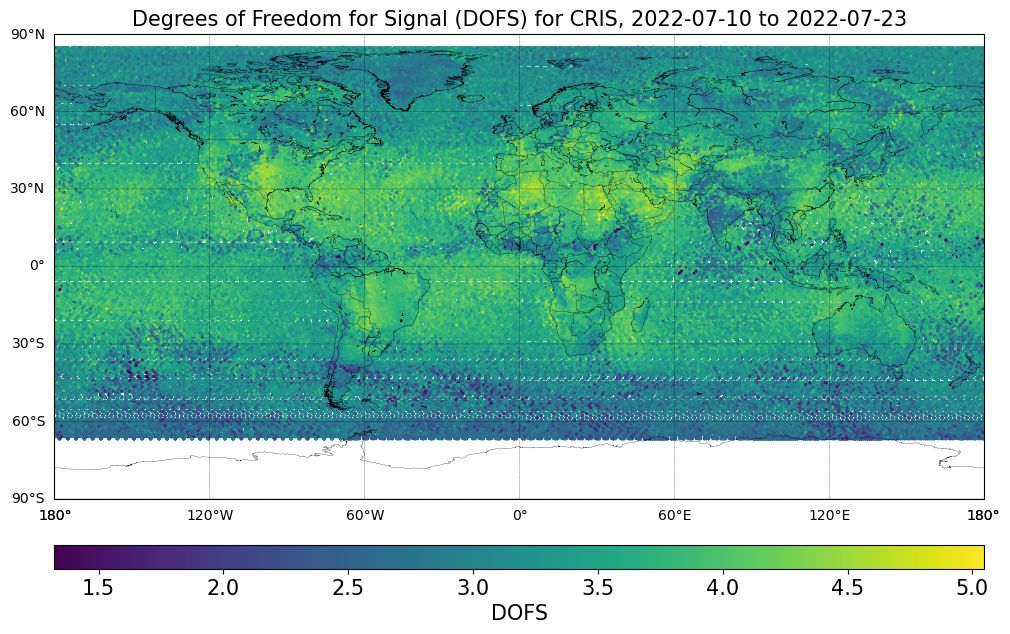

CPU times: user 17.2 s, sys: 383 ms, total: 17.6 s
Wall time: 17.3 s


In [16]:
%%time

# specify figure size (in inches)
plt.figure( figsize=(12, 8) )  

# create a basemap instance
m = Basemap( projection='cyl', resolution='l' )

# draw geographic features, including parallels (latitude lines) and meridians (longitude lines)
m.drawcoastlines(linewidth=0.2)
m.drawcountries(linewidth=0.2)
parallels = np.arange(-90., 91., 30.)
m.drawparallels(parallels, labels=[True,False,False,False], linewidth=0.3)
meridians = np.arange(-180., 181., 60.)
m.drawmeridians(meridians, labels=[False,False,False,True], linewidth=0.3)    

# plot every day of data as a scatter plot
for i in range(len(d_all['latitude'])):
    sc = m.scatter( d_all['longitude'][i], d_all['latitude'][i], c=d_all['signal_dof'][i], cmap='viridis', s=2 )

# add a colorbar
cbar = m.colorbar( sc, location='bottom', pad='10%' )
cbar.ax.tick_params( labelsize=15 ) 
cbar.set_label( 'DOFS', fontsize=15 )

# add a title
plt.title( f'Degrees of Freedom for Signal (DOFS) for {satellite}, {start_date} to {end_date}', fontsize=15 )

# Save figure to PNG file
plt.savefig(f'./images/tropess_{satellite}_dofs_{start_date}_to_{end_date}.png', dpi=300, bbox_inches='tight')

plt.show()
plt.close()

## Plotting a time series

Next we will look at how to plot a time series of tropospheric ozone column. We use the regional, daily averages over the United States.

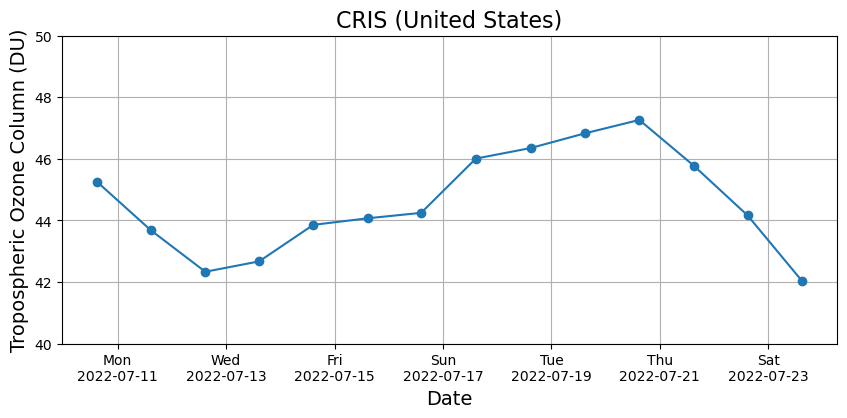

CPU times: user 482 ms, sys: 19.1 ms, total: 501 ms
Wall time: 520 ms


In [19]:
%%time

# specify figure size (in inches)
fig, ax = plt.subplots( figsize=(10, 4) )  

# plot tropospheric column (multiply by 2241.147 to convert to Dobson Units)
plt.plot( dt, d_US['col_t']*2241.147, marker='o' )

# add figure features
if satellite == 'CRIS':
    plt.ylim( (40,50) )
elif satellite == 'OMI':
    plt.ylim( (35,45) )
ax.xaxis.set_major_formatter( mdates.DateFormatter( '%a\n%Y-%m-%d' ) )
plt.xlabel( 'Date', fontsize=14 )
plt.ylabel( 'Tropospheric Ozone Column (DU)', fontsize=14 )
plt.title( f'{satellite} (United States)', fontsize=16 )
plt.grid( True )

# Save figure to PNG file
plt.savefig(f'./images/tropess_{satellite}_tropospheric_column_ozone_time_series_{start_date}_to_{end_date}.png', dpi=300, bbox_inches='tight')

plt.show()
plt.close()

## Investigate profiles from single soundings

Now we will look at the 2 individual soundings from SE Asia, one on a clear day and one on a cloudy day. Their locations are shown in the map below.

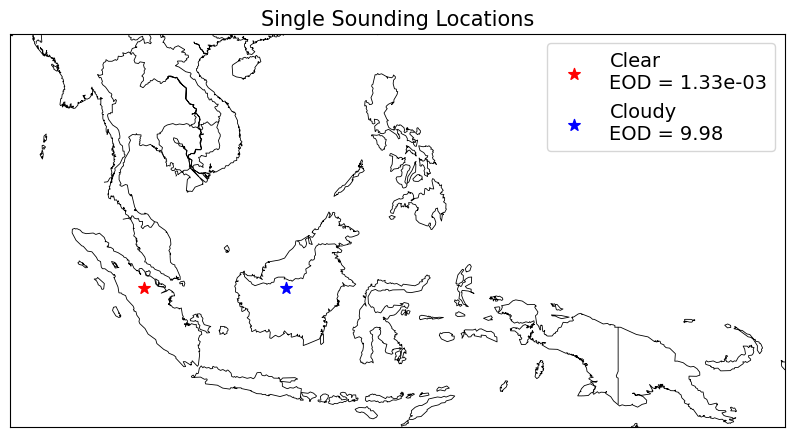

CPU times: user 428 ms, sys: 19.1 ms, total: 447 ms
Wall time: 454 ms


In [20]:
%%time

# specify figure size (in inches)
plt.figure( figsize=(10, 8) )  

# create a basemap instance
m = Basemap( projection='cyl', resolution='l', llcrnrlat=lat_min_loc, urcrnrlat=lat_max_loc, llcrnrlon=lon_min_loc, urcrnrlon=lon_max_loc )

# draw geographic features, including parallels (latitude lines) and meridians (longitude lines)
m.drawcoastlines(linewidth=0.6, color='k')
m.drawcountries(linewidth=0.6, color='k')
m.drawstates(linewidth=0.6, color='k')

# plot each location
sc = m.scatter( d_loc_clear['longitude'], d_loc_clear['latitude'], c='r', s=75, marker='*', label='Clear\nEOD = '+'{:.2e}'.format(ceod_min) )
sc = m.scatter( d_loc_cloud['longitude'], d_loc_cloud['latitude'], c='b', s=75, marker='*', label='Cloudy\nEOD = '+'{:.2f}'.format(ceod_max) )

# add a legend to label the locations
plt.legend( loc='upper right', fontsize=14 )

# add a title
plt.title( 'Single Sounding Locations', fontsize=15 )

# Save figure to PNG file
plt.savefig(f'./images/single_sounding_locations.png', dpi=300, bbox_inches='tight')

plt.show()
plt.close()

### Plot Averaging Kernels and Ozone Profiles from 2 Sounding Locations (see above)

Now we'll plot averaging kernels and ozone profiles for these 2 soundings. Averaging kernels represent the sensitivity that the satellite instrument has at each level of the atmosphere.

In the figure, you will notice that the satellite has near-zero sensitivity in the troposphere on the cloudy day because those altitudes are "hidden" from the instrument (i.e., being blocked by the clouds).

The figures also display the DOFS, or degree of freedom for signal. DOFS is the trace of the averaging kernel, and is another method of representing the sensitivity of the instrument to the total atmosphere. In the cloudy-sky case, the DOFS is lower because the instrument cannot "see" the entire atmosphere.

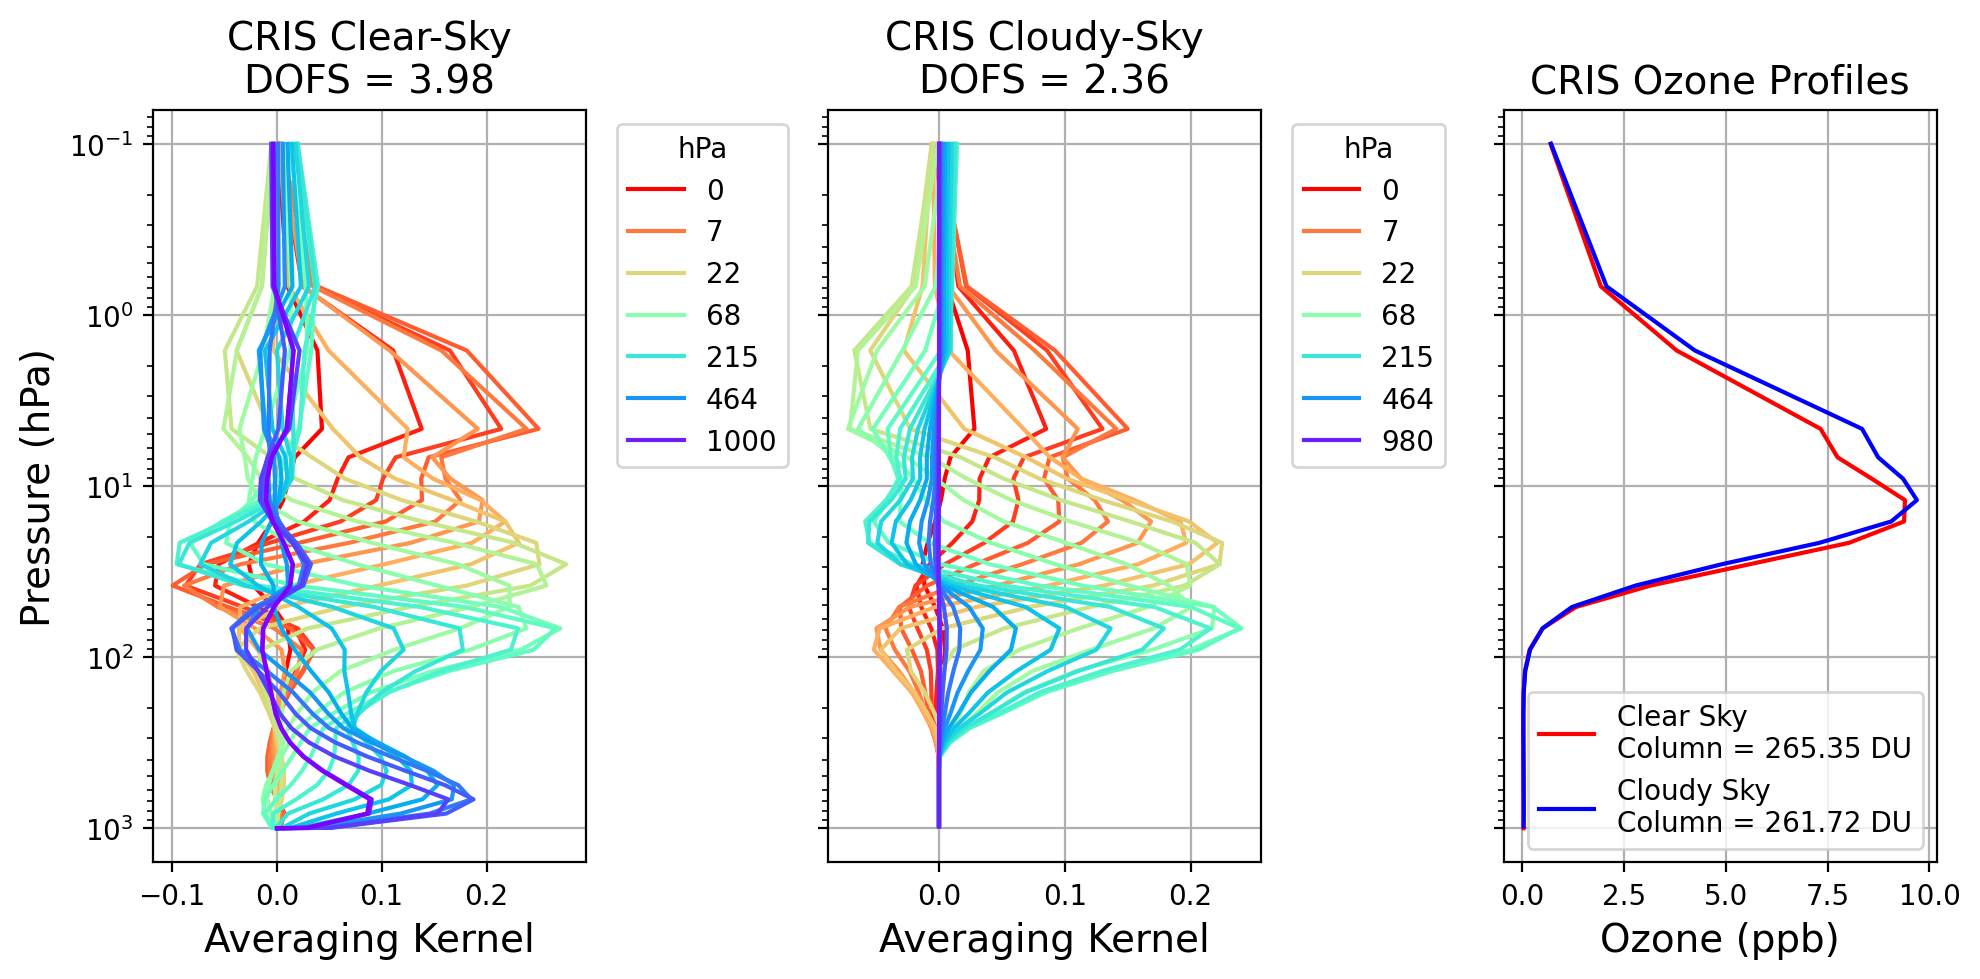

CPU times: user 2.13 s, sys: 52.9 ms, total: 2.18 s
Wall time: 2.19 s


In [21]:
%%time

# specify figure size (in inches)
fig, (ax0, ax1, ax2) = plt.subplots( nrows=1, ncols=3, sharey=True, figsize=(10,5), dpi=200 ) 

# prepare range of colors
colors = plt.cm.rainbow( np.linspace(0,1,d_loc_clear['x'].shape[0]) )

# plot clear-sky on left
newstart = True
for i in range(len(d_loc_clear['pressure']))[::-1]:
    if np.isnan(d_loc_clear['pressure'][i]):
        ax0.semilogy( d_loc_clear['averaging_kernel'][i,:], d_loc_clear['pressure'], c=colors[i] )
    elif newstart == True:
        ax0.semilogy( d_loc_clear['averaging_kernel'][i,:], d_loc_clear['pressure'], c=colors[i], label=str(round(d_loc_clear['pressure'][i])) )
        i_first = i
        newstart = False
    elif (i-i_first) % 4 == 0:
        ax0.semilogy( d_loc_clear['averaging_kernel'][i,:], d_loc_clear['pressure'], c=colors[i], label=str(round(d_loc_clear['pressure'][i])) )
    else:
        ax0.semilogy( d_loc_clear['averaging_kernel'][i,:], d_loc_clear['pressure'], c=colors[i] )
ax0.set_title( f'{satellite} Clear-Sky\nDOFS = '+'{:.2f}'.format(d_loc_clear['signal_dof']), fontsize=14 )
ax0.set_xlabel( 'Averaging Kernel', fontsize=14 )
ax0.set_ylabel( 'Pressure (hPa)', fontsize=14 )
ax0.legend( bbox_to_anchor=(1.04, 1), title='hPa' )

# plot cloudy-sky in middle
newstart = True
for i in range(len(d_loc_cloud['pressure']))[::-1]:
    if np.isnan(d_loc_cloud['pressure'][i]):
        ax1.semilogy( d_loc_cloud['averaging_kernel'][i,:], d_loc_cloud['pressure'], c=colors[i] )
    elif newstart == True:
        ax1.semilogy( d_loc_cloud['averaging_kernel'][i,:], d_loc_cloud['pressure'], c=colors[i], label=str(round(d_loc_cloud['pressure'][i])) )
        i_first = i
        newstart = False
    elif (i-i_first) % 4 == 0:
        ax1.semilogy( d_loc_cloud['averaging_kernel'][i,:], d_loc_cloud['pressure'], c=colors[i], label=str(round(d_loc_cloud['pressure'][i])) )
    else:
        ax1.semilogy( d_loc_cloud['averaging_kernel'][i,:], d_loc_cloud['pressure'], c=colors[i] )
ax1.set_title( f'{satellite} Cloudy-Sky\nDOFS = '+'{:.2f}'.format(d_loc_cloud['signal_dof']), fontsize=14 )
ax1.set_xlabel( 'Averaging Kernel', fontsize=14 )
ax1.legend( bbox_to_anchor=(1.04, 1), title='hPa' )

# plot ozone profiles on right
ax2.plot( d_loc_clear['x']*1e6, d_loc_clear['pressure'], c='r', label='Clear Sky\nColumn = '+'{:.2f}'.format(d_loc_clear['col']*2241.147)+' DU' )
ax2.plot( d_loc_cloud['x']*1e6, d_loc_cloud['pressure'], c='b', label='Cloudy Sky\nColumn = '+'{:.2f}'.format(d_loc_cloud['col']*2241.147)+' DU' )
ax2.set_title( f'{satellite} Ozone Profiles', fontsize=14 )
ax2.set_xlabel( 'Ozone (ppb)', fontsize=14 )
ax2.legend( loc='lower right' )

# format figure
plt.gca().invert_yaxis()
ax0.set_yscale('log')
ax1.set_yscale('log')
ax0.grid( True )
ax1.grid( True )
ax2.grid( True )
plt.tight_layout()    

# Save figure to PNG file
plt.savefig(f'./images/tropess_{satellite}_averaging_kernels_ozone_profiles.png', dpi=300, bbox_inches='tight')

plt.show()
plt.close()

### Now rerun using data from the other satellite!